In [1]:
from method.split import split_folders
from method.cnn import CustomCNN, train_model, predict_model
from method.io import load_data
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix
import datetime
import random
import torch
import numpy as np
import pandas as pd
import os

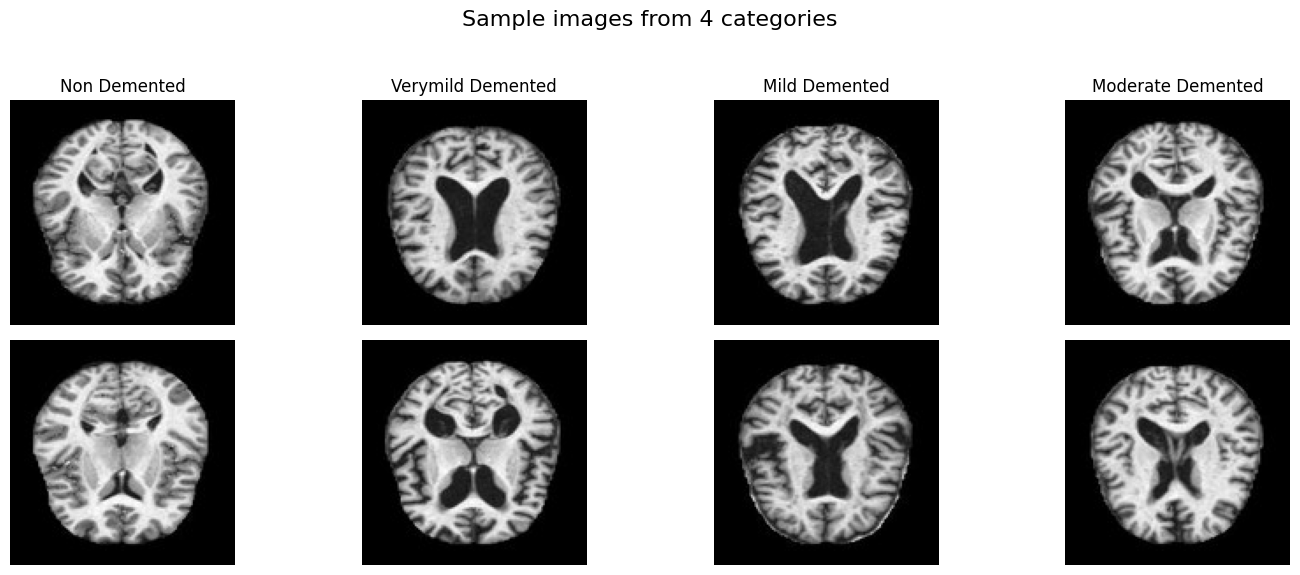

In [2]:
def extract_values_labels(data_list):
    values = [item[0] for item in data_list]
    labels = [item[1] for item in data_list]
    return values, labels

#==============================================================================
# Split filefolders

raw_data_path = 'raw_data'
processed_data_path = 'processed_data'
random_seed = 420
train_ratio, test_ratio, validation_ratio = (0.8, 0.1, 0.1)
split_ratio = [train_ratio, test_ratio, validation_ratio]

if not os.path.exists(processed_data_path):
    split_folders(raw_data_path, processed_data_path, random_seed, split_ratio)         

#==============================================================================
# Hyper parameters

layers = 4
kernel_num = 32
kernel_size = 3
pooling_size = 2
full_connection_neurons = 512
dropout = 0.2
learning_rate = 0.0001
batch_size = 8
epoch = 10
optimizer = 'Adam'
activation = 'relu'
if_plot = True

#==============================================================================
# Load image after splited and Process it

filedir = 'processed_data'          # Directory of whole splited data
splits = ['train', 'test', 'val']           # Different uses of data
classifications = ['non', 'verymild', 'mild', 'moderate']      # Classification of disease degree

train_data, test_data, val_data = load_data(filedir, splits, classifications, transform = True, ifplot = if_plot)

In [3]:
random.seed(5)  # 设置随机种子
random.shuffle(test_data)

train_values, train_labels = extract_values_labels(train_data)          # (5119, 128, 128), (5119,)
test_values, test_labels = extract_values_labels(test_data)             # (642, 128, 128), (642,)
val_values, val_labels = extract_values_labels(val_data)                # (639, 128, 128), (639,)

train_images = torch.Tensor(np.array(train_values)).unsqueeze(1)
train_labels_tensor = torch.Tensor(train_labels)
test_images = torch.Tensor(np.array(test_values)).unsqueeze(1)
test_labels_tensor = torch.Tensor(test_labels)
val_images = torch.Tensor(np.array(val_values)).unsqueeze(1)
val_labels_tensor = torch.Tensor(val_labels)

train_dataset = TensorDataset(train_images, train_labels_tensor)
test_dataset = TensorDataset(test_images, test_labels_tensor)
val_dataset = TensorDataset(val_images, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [6]:
'''Define CNN Model and Device'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(
    input_channels = 1, num_classes = len(classifications), layers = layers, 
    kernel_n = kernel_num, kernel_s = kernel_size, pooling_size = pooling_size,
    activation = activation, neurons = full_connection_neurons, dropout = dropout)
model.to(device)

CustomCNN(
  (layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

In [7]:
'''Fit and Train model and then predict'''
train_model(model, train_loader, val_loader, epochs = epoch, learning_rate = learning_rate, device = device)
predictions = predict_model(model, test_loader, device)         # shape: (642, 4)

The 0 epoch Validation Accuracy: 54.93%
The 1 epoch Validation Accuracy: 59.15%
The 2 epoch Validation Accuracy: 63.85%
The 3 epoch Validation Accuracy: 70.58%
The 4 epoch Validation Accuracy: 69.95%
The 5 epoch Validation Accuracy: 75.12%
The 6 epoch Validation Accuracy: 81.38%
The 7 epoch Validation Accuracy: 87.64%
The 8 epoch Validation Accuracy: 89.67%
The 9 epoch Validation Accuracy: 94.21%


In [11]:
#==============================================================================
# Save results and Analyze

one_hot_predictions = np.zeros_like(predictions)
one_hot_predictions[np.arange(len(predictions)), predictions.argmax(1)] = 1

if not os.path.exists('out'):       # Create out filefolder
    os.makedirs('out')

model_str = str(model)      # Turn model into string
current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
with open('out/cnn_model.txt', 'w') as f:
    if f.tell() == 0:
        f.write(f'File Creation Time: {current_time}\n')
    f.write(model_str)

model_path = 'out/cnn_model.pth'        # save model
torch.save(model.state_dict(), model_path)
np.save('out/prediction_result.npy', one_hot_predictions)
np.save('out/test_labels.npy', np.array(test_labels))

predicted_labels = np.argmax(one_hot_predictions, axis = 1)
true_labels = np.argmax(np.array(test_labels), axis = 1)

accuracy = accuracy_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f'Accuracy: {accuracy * 100:.2f}%')
print('Confusion Matrix:')
print(conf_matrix)

np.savetxt('out/confusion_matrix.txt', conf_matrix, fmt = '%d')

Accuracy: 92.99%
Confusion Matrix:
[[305  13   2   0]
 [ 11 211   2   0]
 [  6  10  75   0]
 [  1   0   0   6]]


In [33]:
from torchsummary import summary
print(summary(model, input_size = (1,128,128)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Conv2d-7          [-1, 256, 16, 16]         295,168
         MaxPool2d-8            [-1, 256, 8, 8]               0
           Dropout-9                [-1, 16384]               0
           Linear-10                  [-1, 512]       8,389,120
           Linear-11                    [-1, 4]           2,052
Total params: 8,779,012
Trainable params: 8,779,012
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forw